In [46]:
import os
import pandas as pd
import numpy as np

# visualization 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

import sklearn 

import datetime as dt
from datetime import timedelta 
from datetime import date

# plotting candlestick graphs
import mplfinance as mpf

# stock data api
# from iexfinance.stocks import Stock
# from iexfinance.stocks import get_historical_data
import quandl as ql
import yfinance as yf
# import helper file for functions
import helper

# tsfresh 
import tsfresh 
from tsfresh import extract_features
from tsfresh import utilities


In [2]:
style.use('ggplot')
# quandl api key activation
ql.ApiConfig.api_key = open("ql_api_token.txt").read()


In [3]:
# Start: 1st trading day in 2014 
start = dt.datetime(2014,1,2)
# latest close date 
end = date.today()
# Using quandl api to retrieve historical data on ticker MSFT (Microsoft)
eod_msft_data = ql.get('EOD/MSFT', start_date=start, end_date=end)
# eod_msft_data.head()
eod_msft_data.tail()
# Free EOD data is limited to end of 2017

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,
2017-12-21,86.05,86.1000,85.400,85.50,17990745.0,0.0,1.0,82.753184,82.801268,82.128087,82.224256,17990745.0
2017-12-22,85.40,85.6300,84.920,85.51,14145841.0,0.0,1.0,82.128087,82.349275,81.666477,82.233873,14145841.0
2017-12-26,85.31,85.5346,85.030,85.40,9891237.0,0.0,1.0,82.041535,82.257530,81.772263,82.128087,9891237.0
2017-12-27,85.65,85.9800,85.215,85.71,14678025.0,0.0,1.0,82.368509,82.685866,81.950175,82.426210,14678025.0
2017-12-28,85.90,85.9300,85.550,85.72,10594344.0,0.0,1.0,82.608931,82.637781,82.272340,82.435827,10594344.0


In [53]:
# Check for any null values in dataset 
eod_msft_data.isnull().values.any() 

False

In [4]:
# trim down dataframe to necessary columns
adj_close_msft_2017 = eod_msft_data[['Volume','Adj_Close']] 
adj_close_msft_2017.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2014-01-02 to 2017-12-28
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Volume     1006 non-null   float64
 1   Adj_Close  1006 non-null   float64
dtypes: float64(2)
memory usage: 23.6 KB


In [5]:
# Get remaining data from Yahoo Finance
msft_yf= yf.download('MSFT',start='2018-01-02',end='2019-12-28')
# msft_yf.head()


[*********************100%***********************]  1 of 1 completed


In [6]:
msft_yf.columns = ['Open','High','Low','Close','Adj_Close','Volume']
msft_yf.head()

,Open,High,Low,Close,Adj_Close,Volume
Date,,,,,,
2018-01-02,86.129997,86.309998,85.500000,85.949997,82.383636,22483800
2018-01-03,86.059998,86.510002,85.970001,86.349998,82.767044,26061400
2018-01-04,86.589996,87.660004,86.570000,87.110001,83.495522,21912000
2018-01-05,87.660004,88.410004,87.430000,88.190002,84.530701,23407100
2018-01-08,88.199997,88.580002,87.599998,88.279999,84.616966,22113000


In [54]:
# Check for any null values in dataset 
msft_yf.isnull().values.any() 

False

In [7]:
adj_close_msft_2019 = msft_yf[['Adj_Close','Volume']]
adj_close_msft_2019.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 501 entries, 2018-01-02 to 2019-12-27
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj_Close  501 non-null    float64
 1   Volume     501 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 11.7 KB


In [8]:
# concatenate dataframes
adj_close_msft_merged = adj_close_msft_2017.append(adj_close_msft_2019)
adj_close_msft_merged.describe()

,Volume,Adj_Close
count,1.507000e+03,1507.000000
mean,2.984602e+07,70.767231
std,1.448462e+07,33.389563
min,7.425603e+06,30.356224
25%,2.128605e+07,42.325807
50%,2.664930e+07,58.911296
75%,3.408979e+07,97.830582
max,2.025224e+08,157.293686


Training was designated as all adjusted close data prior to 2019. Adjusted close price was used here because this price is adjusted for the dividends and stock splits that it may have occurred over the selected period of time.

In [18]:
# test/train data split
train = adj_close_msft_merged['Adj_Close'][:'2018-12-31']
test = adj_close_msft_merged['Adj_Close']['2019-01-01':]
train.head()

Date
2014-01-02    32.248064
2014-01-03    32.031110
2014-01-06    31.354213
2014-01-07    31.597202
2014-01-08    31.033121
Name: Adj_Close, dtype: float64

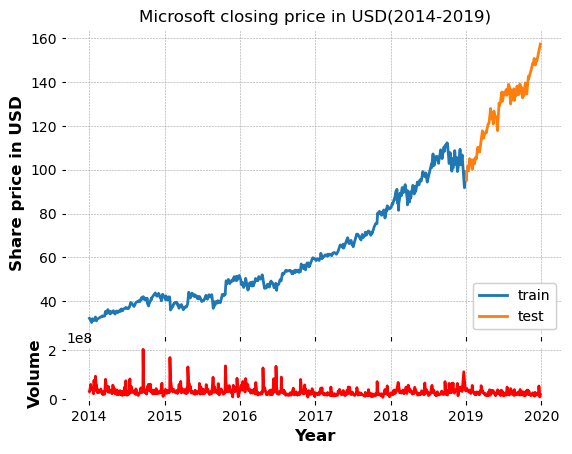

In [41]:
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1,sharex=ax1)
ax1.plot( train, label='train')
ax1.plot( test, label='test')
ax2.plot(adj_close_msft_merged['Volume'],color='red')
ax1.set_title('Microsoft closing price in USD(2014-2019)')
ax1.set(ylabel='Share price in USD')
ax2.set(ylabel='Volume')
ax2.set(xlabel='Year')
leg1 = ax1.legend(loc='lower right')
ax1.add_artist(leg1)
plt.show()

In [11]:
# Daily prices including highs and lows with volume for hockeystick graph
full_msft_df = eod_msft_data[['Open','High','Low','Close','Adj_Close','Volume']].append(msft_yf)
# Creating a candle-stick graph
# If a stock underwent a split, you'd have to create a new dataset based on the Adjusted Close values.
df_ohlc = full_msft_df['Adj_Close'].resample('10D').ohlc()
df_vol = full_msft_df['Volume'].resample('10D').sum()
print (df_ohlc.tail())

                  open        high         low       close
Date                                                      
2019-11-12  145.034821  148.308868  145.034821  147.913040
2019-11-22  148.021912  150.723297  148.021912  149.793152
2019-12-02  147.982330  150.159271  147.744843  150.109772
2019-12-12  151.633667  155.759949  151.633667  155.759949
2019-12-22  155.759949  157.293686  155.730255  157.293686


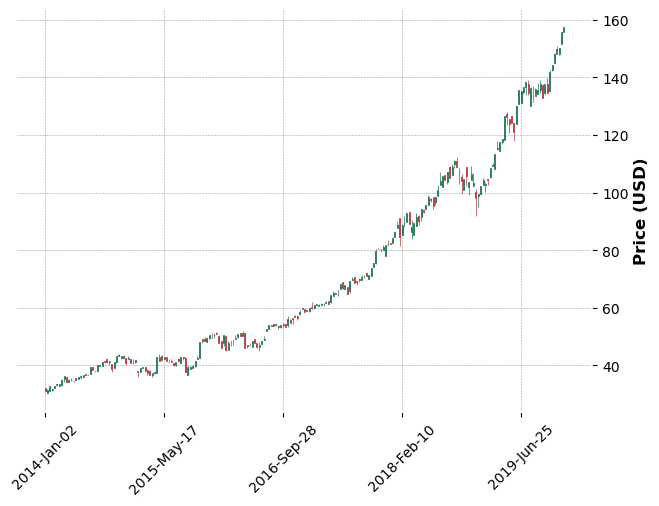

In [12]:
mpf.plot(
    df_ohlc, 
    type='candlestick',
    style='charles',
    ylabel='Price (USD)')


To-Do: Test stationarity and train ARIMA regression model 